In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import config
import sklearn
from sklearn import metrics
from tqdm import tqdm
import config
import designimg as d

In [3]:
oof_path = f'/content/SETI/output/efficientnet_b0_dt0605/oof_df_efficientnet_b0_bs32_size273_dt0605.csv'
print({config.DATA_PATH})

{'/content/drive/MyDrive/SETI/input/'}


In [4]:
oof = pd.read_csv(oof_path)
oof.head()

,predictions,targets,target_ids
0,0.013317,0.0,28093
1,0.021402,0.0,36847
2,0.004123,0.0,46850
3,0.000508,0.0,45410
4,0.006440,0.0,9789


In [5]:
oof.targets.value_counts()

0.0    45471
1.0     4694
Name: targets, dtype: int64

In [6]:
# defining tp, tn, fp, fn from basic

class Metrics():
    def __init__(self, ytrue, ypred):
        self.ytrue = ytrue
        self.ypred = ypred
        
    def true_pos(self):
        tp = 0
        for yt, yp in zip(self.ytrue, self.ypred):
            if yt == 1 and yp == 1:
                tp += 1
        return tp

    def true_neg(self):
        tn = 0
        for yt, yp in zip(self.ytrue, self.ypred):
            if yt == 0 and yp == 0:
                tn += 1
        return tn

    def false_pos(self):
        fp = 0
        for yt, yp in zip(self.ytrue, self.ypred):
            if yt == 0 and yp == 1:
                fp += 1
        return fp

    def false_neg(self):
        fn = 0
        for yt, yp in zip(self.ytrue, self.ypred):
            if yt == 1 and yp == 0:
                fn += 1
        return fn

    def precision(self):
        tp = self.true_pos()
        fp = self.false_pos()
        return tp / (tp + fp)

    def recall(self):
        tp = self.true_pos()
        fn = self.false_neg()  
        return tp / (tp + fn)
    
    def f1(self):
        p = self.precision()
        r = self.recall()
        return 2*p*r / (p +r)
    
    def tpr(self):
        return self.recall()
    
    def fpr(self):
        fp = self.false_pos()
        tn = self.true_neg()
        return fp / (fp + tn)
    
    def roc_auc(self):
        return metrics.roc_auc_score(self.ytrue, self.ypred)
    
    

In [7]:
thresholds = [x/1000 for x in range(1000)]

In [8]:
mDF = pd.DataFrame({
                    'threshold':[],
                    'fp':[], 'fn':[], 'tn':[], 'tp':[],
                    'precision':[], 'recall':[],
                    'tpr':[], 'fpr':[],
                    'f1':[], 'roc_threshold':[],
                    })


In [9]:
for i, threshold in tqdm(enumerate(thresholds)):
    ypred = oof['predictions'].values.tolist()
    ypred = [1 if y > threshold else 0 for y in ypred]
    ytrue = oof['targets'].values.tolist()
    m = Metrics(ytrue, ypred)
    mDF.loc[i, 'threshold'] = threshold
    mDF.loc[i, 'fp'] = m.false_pos()
    mDF.loc[i,'fn'] = m.false_neg()
    mDF.loc[i,'tp'] = m.true_pos()
    mDF.loc[i,'tn'] = m.true_neg()
    mDF.loc[i,'precision'] = m.precision()
    mDF.loc[i,'recall'] = m.recall()
    mDF.loc[i,'tpr'] = m.tpr()
    mDF.loc[i,'fpr'] = m.fpr()
    mDF.loc[i,'f1'] = m.f1()
    mDF.loc[i,'roc_threshold'] = m.roc_auc()

1000it [01:09, 14.38it/s]


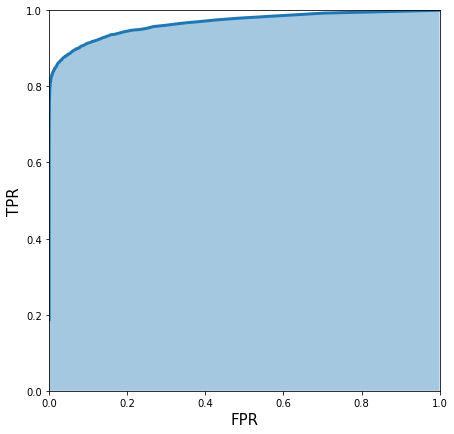

In [10]:
plt.figure(figsize=(7,7))
plt.fill_between(mDF['fpr'].values.tolist(), mDF['tpr'].values.tolist(), alpha = 0.4)
plt.plot(mDF['fpr'].values.tolist(), mDF['tpr'].values.tolist(), lw = 3)
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.xlabel('FPR', fontsize = 15)
plt.ylabel('TPR', fontsize = 15)
plt.show()

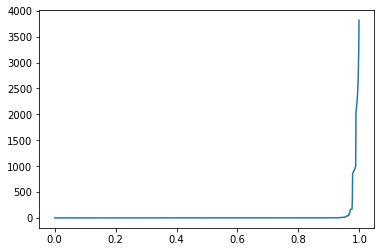

In [11]:
mDF['sweet_spot'] = (mDF['fn']+1)/( pow(mDF['fp'],2) + 1)
plt.plot(mDF['threshold'], mDF['sweet_spot'])
plt.show()

In [12]:
mDF.query('threshold >0.9 and threshold < 0.95')

,threshold,fp,fn,tn,tp,precision,recall,tpr,fpr,f1,roc_threshold,sweet_spot
901,0.901,28.0,1234.0,45443.0,3460.0,0.991972,0.737111,0.737111,0.000616,0.845759,0.868248,1.573248
902,0.902,28.0,1236.0,45443.0,3458.0,0.991968,0.736685,0.736685,0.000616,0.845477,0.868035,1.575796
903,0.903,28.0,1243.0,45443.0,3451.0,0.991952,0.735194,0.735194,0.000616,0.844488,0.867289,1.584713
904,0.904,28.0,1249.0,45443.0,3445.0,0.991938,0.733916,0.733916,0.000616,0.843639,0.866650,1.592357
905,0.905,28.0,1252.0,45443.0,3442.0,0.991931,0.733277,0.733277,0.000616,0.843214,0.866330,1.596178
906,0.906,27.0,1256.0,45444.0,3438.0,0.992208,0.732424,0.732424,0.000594,0.842750,0.865915,1.721918
907,0.907,27.0,1256.0,45444.0,3438.0,0.992208,0.732424,0.732424,0.000594,0.842750,0.865915,1.721918
908,0.908,27.0,1259.0,45444.0,3435.0,0.992201,0.731785,0.731785,0.000594,0.842325,0.865596,1.726027
909,0.909,26.0,1260.0,45445.0,3434.0,0.992486,0.731572,0.731572,0.000572,0.842286,0.865500,1.862629
910,0.910,26.0,1264.0,45445.0,3430.0,0.992477,0.730720,0.730720,0.000572,0.841718,0.865074,1.868538


In [13]:
threshold_fp = 0.93 #to identify the real fp set it high
oof['predictions_bool_fp'] = oof['predictions'].apply(lambda x : 0 if x < threshold_fp else 1)  
oof['fp'] = oof.apply(lambda x: Metrics([x['targets']],
                                        [x['predictions_bool_fp']]).false_pos(), axis = 1) 
threshold_fn = 0.20 # to identify the real fn set it low
oof['predictions_bool_fn'] = oof['predictions'].apply(lambda x : 0 if x < threshold_fn else 1)  
oof['fn'] = oof.apply(lambda x: Metrics([x['targets']],
                                        [x['predictions_bool_fn']]).false_neg(), axis = 1)

In [14]:
oof.query('fp == 1').head()

,predictions,targets,target_ids,predictions_bool_fp,fp,predictions_bool_fn,fn
326,0.936765,0.0,37604,1,1,1,0
1264,0.955484,0.0,4185,1,1,1,0
7573,0.969919,0.0,48810,1,1,1,0
7650,0.937150,0.0,4870,1,1,1,0
14022,0.977619,0.0,49428,1,1,1,0


In [15]:
tr = pd.read_csv(f'{config.DATA_PATH}train_labels.csv')
trfp = tr[tr.index.isin(oof.query('fp == 1')['target_ids'].values.tolist())]
trfn = tr[tr.index.isin(oof.query('fn == 1')['target_ids'].values.tolist())]

In [16]:
# negative images classified as positive (fp)
print(trfp.head(), '\n\n', trfn.head())

                 id  target
165    00db570b18df       0
4185   150be16760e4       0
4719   17dfd082a922       0
4870   18a0ca20b05d       0
14811  4b939ac620f5       0 

                id  target
54   004cd81a867c       1
76   00667e94a985       1
85   0078157399c9       1
148  00ca1a44f310       1
211  011184c5f640       1


In [17]:
def disp_image(image_path):
    img = np.load(image_path)
#     print(img)
    plt.imshow(img)
    plt.show()

In [18]:
#images classified as positive but aren't
pos_imgs = trfp.id.values
for i in pos_imgs[0:10]:
    print(i)
    disp_image(f'{config.RESIZED_IMAGE_PATH}train/{i}.npy')

00db570b18df


AttributeError: module 'config' has no attribute 'RESIZED_IMAGE_PATH'

In [ ]:
#images classified as negative but are positive 
pos_imgs = trfn.id.values
for i, img in enumerate(pos_imgs[0:10]):
    print(i, img)
    disp_image(f'{config.RESIZED_IMAGE_PATH}train/{img}.npy')

In [ ]:
trl = pd.read_csv(f'{config.DATA_PATH}train_labels.csv')
trlp = trl[trl['target'] == 1]
trln = trl[trl['target'] == 0]
trln.query(f'''id == '1ba80569438e' ''')

In [ ]:
trl = pd.read_csv(f'{config.DATA_PATH}train_labels.csv')
trlp = trl[trl['target'] == 1]
trln = trl[trl['target'] == 0]
trlp.query(f'''id == '00667e94a985' ''')

In [ ]:
# trying to enhance needle
import cv2
import albumentations as A
from PIL import Image

In [ ]:
pilimg.show()

In [ ]:
i = '0078157399c9'
img = np.load(f'{config.DATA_PATH}train/{i[0]}/{i}.npy')[0].astype(float)
# img = np.amax(img) - img

In [ ]:
np.max(img)

In [ ]:
len(np.unique(img))

In [ ]:
p = Image.fromarray(img)
p.show()

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
import albumentations as B
import numpy as np
import config
import matplotlib.pyplot as plt
import cv2
i = '0078157399c9'
img = np.load(f'{config.DATA_PATH}train/{i[0]}/{i}.npy')[0].astype(np.float32)
img = (img - np.min(img))/(np.max(img) - np.min(img))
img = np.max(img) - img
# print(img)


# brightness 1 -- all black
# transform = B.RandomBrightnessContrast(brightness_limit = [0, 0], contrast_limit = [0.5, 0.5], p =1)

# transform = B.Sharpen(alpha = (1), lightness = (1, 1), p=1)
# transform = B.ColorJitter(
# #                             brightness = (0.0,0.0),
#                             contrast = (0.2, 0.2),
#                             saturation = 0.2,
#                             hue = 0.2, p =1)
# transform = B.RandomToneCurve(scale = 0.4, p=1)
aug = transform(image = img)['image']
# # aug_img.shape

plt.figure(figsize=(16,10))
plt.imshow(aug)
plt.show()
plt.figure(figsize=(16,10))
plt.imshow(img)
plt.show()

In [ ]:
np.min(img)

In [ ]:
#display original image
def disp_origimage(image_path):
    img = np.load(image_path)
    for i in range(6):
        print(i)
        plt.figure(figsize = (16,10))
        plt.imshow(img[i].astype(float))
        plt.show()
# show fn in original size    
i = trfn.id.values[1]
print(i)
disp_origimage(f'{config.DATA_PATH}train/{i[0]}/{i}.npy')